# Implement PINN for the heat equation

The 1 dimensional heat equation is: 

$$ u_t(t, x) = u_{xx}(t, x), \quad t \in (0, T], \quad x \in [-1, 1] $$


where: 
- ut(t, x) represents the temperature at time t and position x
- ut is the partial derivative of u with respect to time t, indicating how the temperature changes over time.
- u xx is the second partial derivative of u with respect to the spatial coordinate x, indicating how the temperature changes with respect to position.

This equation is a fundamental partial differential equation (PDE) used in mathematical physics to describe the distribution of heat (or variation in temperature) in a given region over time.

The heat equation \( u_t(t, x) = u_{xx}(t, x) \) is used to model the distribution of heat in a given region over time.



With boundary conditions:

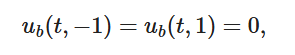

and initial condition:

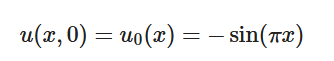



We want to obtain the solution of the heat equation between [-1, 1] with a PINN.

For that, we are going to approximate the underlying solution with a Feedforward dense natural network with tunable parameters θ:

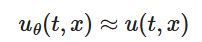

First define the residuals:

- Interior residual (Physics loss)

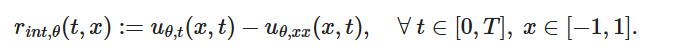


- Spatial boundary residual (boundary conditions -> Boundary loss)

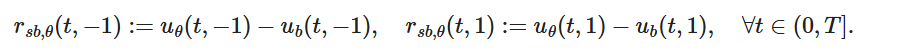

- Temporal boundary residual (initial condition - also boundary loss)

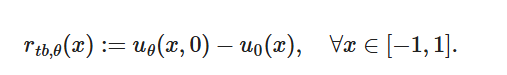

So the loss function is defined by:


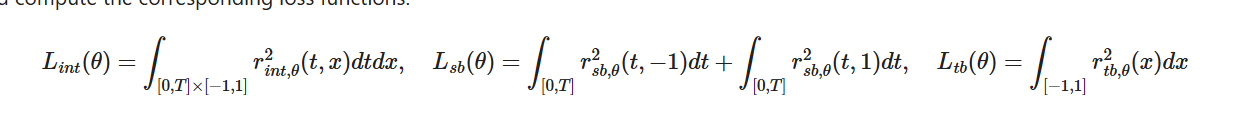

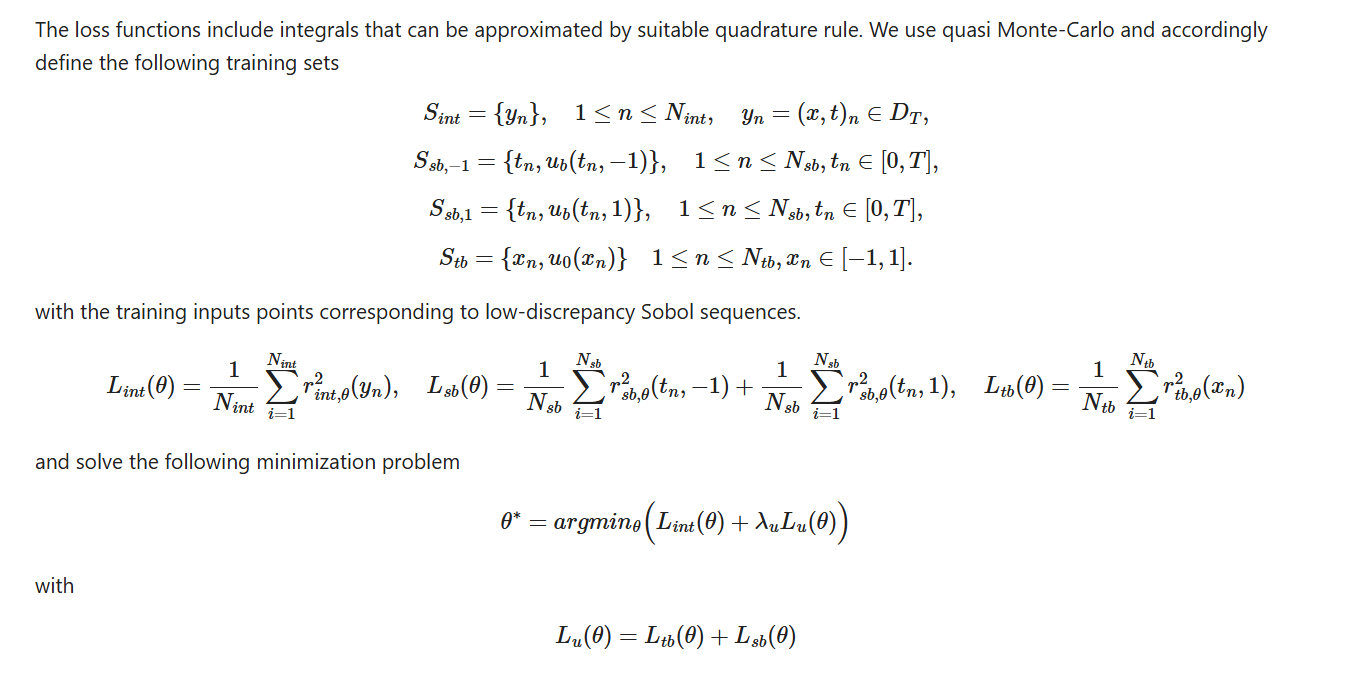

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from common import NeuralNet
import time
torch.manual_seed(128)

In [70]:
class Pinns:
    def __init__(self, n_int_, n_sb_, n_tb_):
        self.n_int = n_int_
        self.n_sb = n_sb_
        self.n_tb = n_tb_

        # Extrema of the solution domain (t,x) in [0,0.6]x[-1,1]
        #  the solution domain for the variables t (time) and x (space)  
        # is defined within the ranges [0,0.6] for time

        self.domain_extrema = torch.tensor([[0, 0.6],  # Time dimension
                                            [-1, 1]])  # Space dimension 

        # Number of space dimensions
        self.space_dimensions = 1

        # Parameter to balance role of data and PDE
        self.lambda_u = 10

        # F Dense NN to approximate the solution of the underlying heat equation
        self.approximate_solution = NeuralNet(input_dimension=self.domain_extrema.shape[0], 
                                              output_dimension=1,
                                              n_hidden_layers=4,
                                              neurons=20,
                                              regularization_param=0.,
                                              regularization_exp=2.,
                                              retrain_seed=42)
        '''self.approximate_solution = MultiVariatePoly(self.domain_extrema.shape[0], 3)'''

        # Generator of Sobol sequences
        self.soboleng = torch.quasirandom.SobolEngine(dimension=self.domain_extrema.shape[0])

        # Training sets S_sb, S_tb, S_int as torch dataloader
        self.training_set_sb, self.training_set_tb, self.training_set_int = self.assemble_datasets()

    ################################################################################################
    # Function to linearly transform a tensor whose value are between 0 and 1
    # to a tensor whose values are between the domain extrema
    def convert(self, tens):
        assert (tens.shape[1] == self.domain_extrema.shape[0])
        return tens * (self.domain_extrema[:, 1] - self.domain_extrema[:, 0]) + self.domain_extrema[:, 0]

    # Initial condition to solve the heat equation u0(x)=-sin(pi x)
    def initial_condition(self, x):
        return -torch.sin(np.pi * x)

    # Exact solution for the heat equation ut = u_xx with the IC above
    def exact_solution(self, inputs):
        t = inputs[:, 0]
        x = inputs[:, 1]

        u = -torch.exp(-np.pi ** 2 * t) * torch.sin(np.pi * x)
        return u

    ################################################################################################
    # Function returning the input-output tensor required to assemble the training set S_tb corresponding to the temporal boundary
    def add_temporal_boundary_points(self):
        t0 = self.domain_extrema[0, 0]
        input_tb = self.convert(self.soboleng.draw(self.n_tb))
        input_tb[:, 0] = torch.full(input_tb[:, 0].shape, t0)
        output_tb = self.initial_condition(input_tb[:, 1]).reshape(-1, 1)

        return input_tb, output_tb

    # Function returning the input-output tensor required to assemble the training set S_sb corresponding to the spatial boundary
    def add_spatial_boundary_points(self):
        x0 = self.domain_extrema[1, 0]
        xL = self.domain_extrema[1, 1]

        input_sb = self.convert(self.soboleng.draw(self.n_sb))

        input_sb_0 = torch.clone(input_sb)
        input_sb_0[:, 1] = torch.full(input_sb_0[:, 1].shape, x0)

        input_sb_L = torch.clone(input_sb)
        input_sb_L[:, 1] = torch.full(input_sb_L[:, 1].shape, xL)

        output_sb_0 = torch.zeros((input_sb.shape[0], 1))
        output_sb_L = torch.zeros((input_sb.shape[0], 1))

        return torch.cat([input_sb_0, input_sb_L], 0), torch.cat([output_sb_0, output_sb_L], 0)

    #  Function returning the input-output tensor required to assemble the training set S_int corresponding to the interior domain where the PDE is enforced
    def add_interior_points(self):
        input_int = self.convert(self.soboleng.draw(self.n_int))
        output_int = torch.zeros((input_int.shape[0], 1))
        return input_int, output_int

    # Function returning the training sets S_sb, S_tb, S_int as dataloader
    def assemble_datasets(self):
        input_sb, output_sb = self.add_spatial_boundary_points()   # S_sb
        input_tb, output_tb = self.add_temporal_boundary_points()  # S_tb
        input_int, output_int = self.add_interior_points()         # S_int

        training_set_sb = DataLoader(torch.utils.data.TensorDataset(input_sb, output_sb), batch_size=2*self.space_dimensions*self.n_sb, shuffle=False)
        training_set_tb = DataLoader(torch.utils.data.TensorDataset(input_tb, output_tb), batch_size=self.n_tb, shuffle=False)
        training_set_int = DataLoader(torch.utils.data.TensorDataset(input_int, output_int), batch_size=self.n_int, shuffle=False)

        return training_set_sb, training_set_tb, training_set_int

    ################################################################################################
    # Function to compute the terms required in the definition of the TEMPORAL boundary residual
    def apply_initial_condition(self, input_tb):
        u_pred_tb = self.approximate_solution(input_tb)
        return u_pred_tb

    # Function to compute the terms required in the definition of the SPATIAL boundary residual
    def apply_boundary_conditions(self, input_sb):
        u_pred_sb = self.approximate_solution(input_sb)

        return u_pred_sb

    # # Function to compute the PDE residuals
    def compute_pde_residual(self, input_int):
        input_int.requires_grad = True
        u = self.approximate_solution(input_int)

        # grad compute the gradient of a "SCALAR" function L with respect to some input nxm TENSOR Z=[[x1, y1],[x2,y2],[x3,y3],...,[xn,yn]], m=2
        # it returns grad_L = [[dL/dx1, dL/dy1],[dL/dx2, dL/dy2],[dL/dx3, dL/dy3],...,[dL/dxn, dL/dyn]]
        # Note: pytorch considers a tensor [u1, u2,u3, ... ,un] a vectorial function
        # whereas sum_u = u1 + u2 + u3 + u4 + ... + un as a "scalar" one

        # In our case ui = u(xi), therefore the line below returns:
        # grad_u = [[dsum_u/dx1, dsum_u/dy1],[dsum_u/dx2, dsum_u/dy2],[dsum_u/dx3, dL/dy3],...,[dsum_u/dxm, dsum_u/dyn]]
        # and dsum_u/dxi = d(u1 + u2 + u3 + u4 + ... + un)/dxi = d(u(x1) + u(x2) u3(x3) + u4(x4) + ... + u(xn))/dxi = dui/dxi
        grad_u = torch.autograd.grad(u.sum(), input_int, create_graph=True)[0]
        grad_u_t = grad_u[:, 0]
        grad_u_x = grad_u[:, 1]
        grad_u_xx = torch.autograd.grad(grad_u_x.sum(), input_int, create_graph=True)[0][:, 1]

        # u_sq = u ** 2
        # grad_u_sq_x = torch.autograd.grad(u_sq.sum(), input_int, create_graph=True)[0][:, 1]

        residual = grad_u_t - grad_u_xx
        return residual.reshape(-1, )



    # # Function to compute the total loss (weighted sum of spatial boundary loss, temporal boundary loss and interior loss)
    def compute_loss(self, inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=True):
        u_pred_sb = self.apply_boundary_conditions(inp_train_sb)
        u_pred_tb = self.apply_initial_condition(inp_train_tb)

        assert (u_pred_sb.shape[1] == u_train_sb.shape[1])
        assert (u_pred_tb.shape[1] == u_train_tb.shape[1])


        r_int = self.compute_pde_residual(inp_train_int)
        r_sb = u_train_sb - u_pred_sb
        r_tb = u_train_tb - u_pred_tb

        loss_sb = torch.mean(abs(r_sb) ** 2)
        loss_tb = torch.mean(abs(r_tb) ** 2)
        loss_int = torch.mean(abs(r_int) ** 2)

        loss_u = loss_sb + loss_tb

        loss = torch.log10(self.lambda_u * (loss_sb + loss_tb) + loss_int)
        if verbose: print("Total loss: ", round(loss.item(), 4), "| PDE Loss: ", round(torch.log10(loss_u).item(), 4), "| Function Loss: ", round(torch.log10(loss_int).item(), 4))

        return loss

    # ################################################################################################
    def fit(self, num_epochs, optimizer, verbose=True):
        history = list()

        # Loop over epochs
        for epoch in range(num_epochs):
            if verbose: print("################################ ", epoch, " ################################")

            for j, ((inp_train_sb, u_train_sb), (inp_train_tb, u_train_tb), (inp_train_int, u_train_int)) in enumerate(zip(self.training_set_sb, self.training_set_tb, self.training_set_int)):
                def closure():
                    optimizer.zero_grad()
                    loss = self.compute_loss(inp_train_sb, u_train_sb, inp_train_tb, u_train_tb, inp_train_int, verbose=verbose)
                    loss.backward()

                    history.append(loss.item())
                    return loss

                optimizer.step(closure=closure)

        print('Final Loss: ', history[-1])

        return history

    

In [71]:
# Solve the heat equation:
# u_t = u_xx, (t,x) in [0, 0.1]x[-1,1]
# with zero dirichlet BC and
# u(x,0)= -sin(pi x)

n_int = 256  # number of interior points

# enforce boundary conditions such as Dirichlet (fixed value) or Neumann (fixed gradient) conditions
# initial residual or temporal boundary:
# the initial condition is what is given at the temporal bound so this object here is what is the temporal boundary residua
n_sb = 64 # number of spatial boundary points 


# temporal boundaries of the domain.
n_tb = 64 # number of temporal boundary points

pinn = Pinns(n_int, n_sb, n_tb)

In [72]:
from torchsummary import summary

# Visualize the architecture of the approximate_solution neural network in pinn
summary(pinn.approximate_solution, input_size=(2,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
              Tanh-2                   [-1, 20]               0
            Linear-3                   [-1, 20]             420
              Tanh-4                   [-1, 20]               0
            Linear-5                   [-1, 20]             420
              Tanh-6                   [-1, 20]               0
            Linear-7                   [-1, 20]             420
              Tanh-8                   [-1, 20]               0
            Linear-9                    [-1, 1]              21
Total params: 1,341
Trainable params: 1,341
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
-----------------------------------------------

In [73]:
# Plot the input training points
input_sb_, output_sb_ = pinn.add_spatial_boundary_points()
input_tb_, output_tb_ = pinn.add_temporal_boundary_points()
input_int_, output_int_ = pinn.add_interior_points()

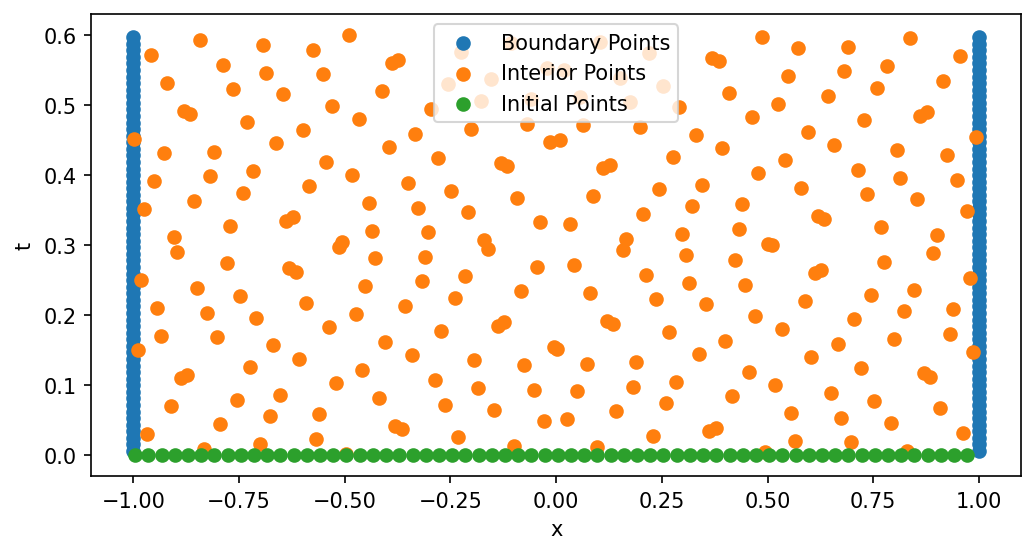

In [74]:
plt.figure(figsize=(8, 4), dpi=150)
plt.scatter(input_sb_[:, 1].detach().numpy(), input_sb_[:, 0].detach().numpy(), label="Boundary Points")
plt.scatter(input_int_[:, 1].detach().numpy(), input_int_[:, 0].detach().numpy(), label="Interior Points")
plt.scatter(input_tb_[:, 1].detach().numpy(), input_tb_[:, 0].detach().numpy(), label="Initial Points")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
plt.show()

In [75]:

optimizer_LBFGS = optim.LBFGS(pinn.approximate_solution.parameters(),
                              lr=float(0.5),
                              max_iter=50000,
                              max_eval=50000,
                              history_size=150,
                              line_search_fn="strong_wolfe",
                              tolerance_change=1.0 * np.finfo(float).eps)

optimizer_LBFGS

LBFGS (
Parameter Group 0
    history_size: 150
    line_search_fn: strong_wolfe
    lr: 0.5
    max_eval: 50000
    max_iter: 50000
    tolerance_change: 2.220446049250313e-16
    tolerance_grad: 1e-07
)

In [76]:

optimizer_ADAM = optim.Adam(pinn.approximate_solution.parameters(),
                            lr=float(0.001))

optimizer_ADAM

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [77]:
n_epochs = 1

hist = pinn.fit(num_epochs=n_epochs,
                optimizer=optimizer_LBFGS,
                verbose=True)

################################  0  ################################
Total loss:  1.5613 | PDE Loss:  0.3077 | Function Loss:  1.2072
Total loss:  1.4913 | PDE Loss:  0.226 | Function Loss:  1.1513
Total loss:  1.2927 | PDE Loss:  0.1691 | Function Loss:  0.6867
Total loss:  1.1611 | PDE Loss:  0.0286 | Function Loss:  0.5811
Total loss:  1.5439 | PDE Loss:  0.4642 | Function Loss:  0.7685
Total loss:  0.9226 | PDE Loss:  -0.2081 | Function Loss:  0.3374
Total loss:  0.8295 | PDE Loss:  -0.2897 | Function Loss:  0.2098
Total loss:  0.6848 | PDE Loss:  -0.4076 | Function Loss:  -0.0329
Total loss:  0.6451 | PDE Loss:  -0.4317 | Function Loss:  -0.1451
Total loss:  0.5332 | PDE Loss:  -0.5277 | Function Loss:  -0.3503
Total loss:  0.4889 | PDE Loss:  -0.5868 | Function Loss:  -0.3072
Total loss:  0.4244 | PDE Loss:  -0.6602 | Function Loss:  -0.3277
Total loss:  0.3654 | PDE Loss:  -0.7158 | Function Loss:  -0.4028
Total loss:  0.3375 | PDE Loss:  -0.7474 | Function Loss:  -0.4131
Total

Total loss:  -0.1692 | PDE Loss:  -1.3524 | Function Loss:  -0.6325
Total loss:  -0.2085 | PDE Loss:  -1.3827 | Function Loss:  -0.6894
Total loss:  -0.2375 | PDE Loss:  -1.4244 | Function Loss:  -0.694
Total loss:  -0.272 | PDE Loss:  -1.5127 | Function Loss:  -0.643
Total loss:  -0.2944 | PDE Loss:  -1.5817 | Function Loss:  -0.6096
Total loss:  -0.3172 | PDE Loss:  -1.6542 | Function Loss:  -0.5851
Total loss:  -0.3438 | PDE Loss:  -1.6985 | Function Loss:  -0.597
Total loss:  -0.3641 | PDE Loss:  -1.7647 | Function Loss:  -0.5843
Total loss:  -0.3841 | PDE Loss:  -1.7682 | Function Loss:  -0.6154
Total loss:  -0.4301 | PDE Loss:  -1.7796 | Function Loss:  -0.6875
Total loss:  -0.4608 | PDE Loss:  -1.7708 | Function Loss:  -0.7531
Total loss:  -0.4854 | PDE Loss:  -1.7947 | Function Loss:  -0.7784
Total loss:  -0.5199 | PDE Loss:  -1.827 | Function Loss:  -0.815
Total loss:  -0.5521 | PDE Loss:  -1.8854 | Function Loss:  -0.8231
Total loss:  -0.5821 | PDE Loss:  -1.9923 | Function L

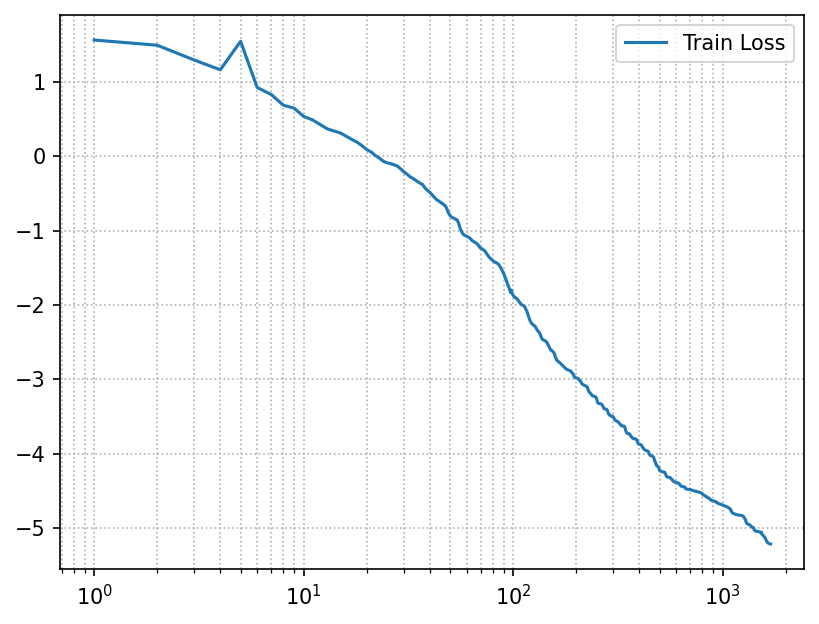

In [78]:
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, len(hist) + 1), hist, label="Train Loss")
plt.xscale("log")
plt.legend()

In [79]:

def plotting(pinn: Pinns):
    inputs = pinn.soboleng.draw(100000)
    inputs = pinn.convert(inputs)

    output = pinn.approximate_solution(inputs).reshape(-1, )
    exact_output = pinn.exact_solution(inputs).reshape(-1, )

    fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
    im1 = axs[0].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=exact_output.detach(), cmap="jet")
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("t")
    plt.colorbar(im1, ax=axs[0])
    axs[0].grid(True, which="both", ls=":")
    im2 = axs[1].scatter(inputs[:, 1].detach(), inputs[:, 0].detach(), c=output.detach(), cmap="jet")
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("t")
    plt.colorbar(im2, ax=axs[1])
    axs[1].grid(True, which="both", ls=":")
    axs[0].set_title("Exact Solution")
    axs[1].set_title("Approximate Solution")

    plt.show()

    err = (torch.mean((output - exact_output) ** 2) / torch.mean(exact_output ** 2)) ** 0.5 * 100
    print("L2 Relative Error Norm: ", err.item(), "%")

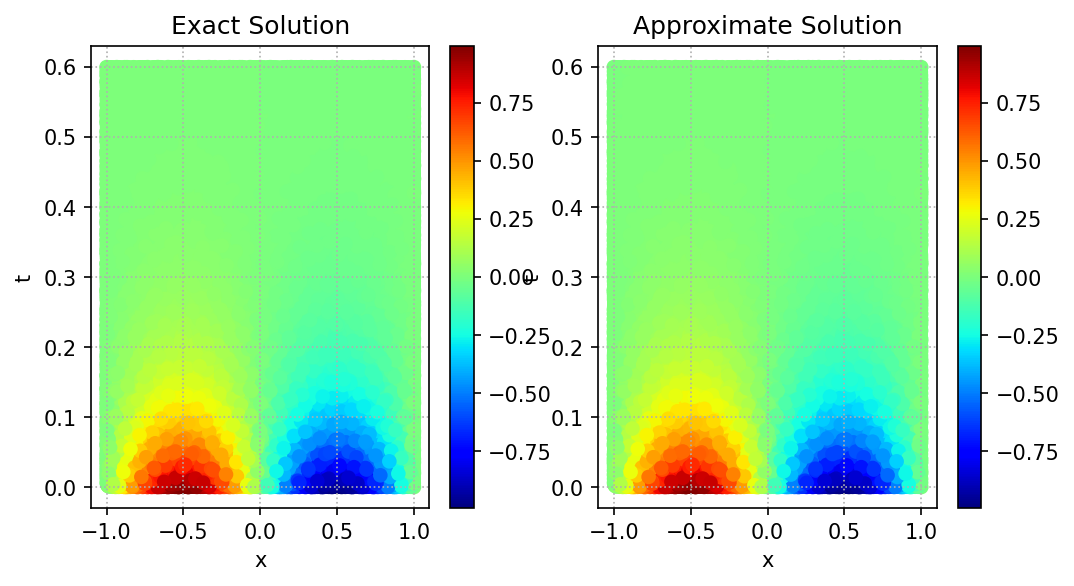

L2 Relative Error Norm:  0.07061528414487839 %


In [80]:
plotting(pinn)